In [5]:
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
from scipy.optimize import curve_fit

Definizione variabili del sitema

In [6]:
t, b_dens, air_dens, coul_const, visc_const, r, height, c = sp.symbols('t, b_dens, air_dens, coul_const, visc_const, r, height, c')
y = sp.symbols('y', cls= sp.Function)
y = y(t)
y_d = sp.diff(y, t)
y_dd = sp.diff(y_d, t)

Estrazione dei dati dal file

In [ ]:
file = np.loadtxt('mass_A.txt')

colonna1 = file[:, 0]  # Prima colonna
colonna2 = file[:, 1]  # Seconda colonna

time_data = colonna1.tolist()
pos_data = colonna2.tolist()
pos_data.reverse()
real_position = (-1)*np.array(pos_data)

Definizione e risoluzione equazioni del moto

In [8]:
equation1 = (b_dens * (4./3.) * sp.pi * r**3) * (-y_dd) - (b_dens * (4./3.) * sp.pi * r**3)*9.81  + air_dens * (4./3.) * sp.pi * r**3 * 9.81 + 6*sp.pi*(r)*visc_const * (y_d) 

y_dd = (1/(b_dens * (4./3.) * sp.pi * r**3)  )*((-b_dens * (4./3.) * sp.pi * r**3)*9.81 + (air_dens * (4./3.) * sp.pi * r**3)*9.81 + 6*sp.pi*(r)*visc_const * sp.diff(y, t) + coul_const / y**2)

sol1 = y_d

equation1 = equation1.simplify()

y_0 = abs(pos_data[0])
v_0 = 0
position = sp.dsolve(equation1, y, ics={y.subs(t, 0): y_0, y_d.subs(t, 0): v_0})
velocity = sp.diff(position, t)

position = position.rhs.simplify().subs({  
    air_dens: 1.293, 
    visc_const: 1.81e-5, 
    r: 0.041,        
    height: abs(pos_data[0])    
}) #prende solo il lato destro dell'equazione
y_func = sp.lambdify([t, b_dens], position, 'numpy')
solution1 = sp.lambdify(y_d, sol1)
solution2 = sp.lambdify([b_dens, air_dens, coul_const, visc_const, r, height, y, y_d], y_dd)

Fit dell'equazione senza coulomb

In [9]:
def fit_func(t, b_dens):
    return y_func(t, b_dens)

In [10]:
initial_guess = [1]
params, covariance = curve_fit(fit_func, colonna1, colonna2, p0=initial_guess)
Bubble_density = params

In [11]:
y = y_func(np.array(time_data), *params)
indexes = np.where(y >= 0.)
y_fit = y[indexes]
time_fit = np.array(time_data)[indexes]

Risoluzione numerica equazione con coulomb

In [12]:
def solve(S, t):
    return[
        solution1(S[1]),
        solution2(b_dens, air_dens, coul_const, visc_const, r, height, S[0], S[1])
]

In [13]:
t = np.linspace(min(time_data), max(time_data), 1000)
b_dens = Bubble_density[0]  
air_dens =  1.293
coul_const = 1.e-4 
visc_const = 1.81e-5 
r = 0.041      
height = abs(pos_data[0])       
bubble_motion = integrate.odeint(solve, [0.01, 0], t)

In [14]:
coulomb_position = height - bubble_motion.T[0]
indexes = np.where(coulomb_position >= 0.)
coulomb_position = coulomb_position[indexes]
t = t[indexes]

Rappresentazione dei plot

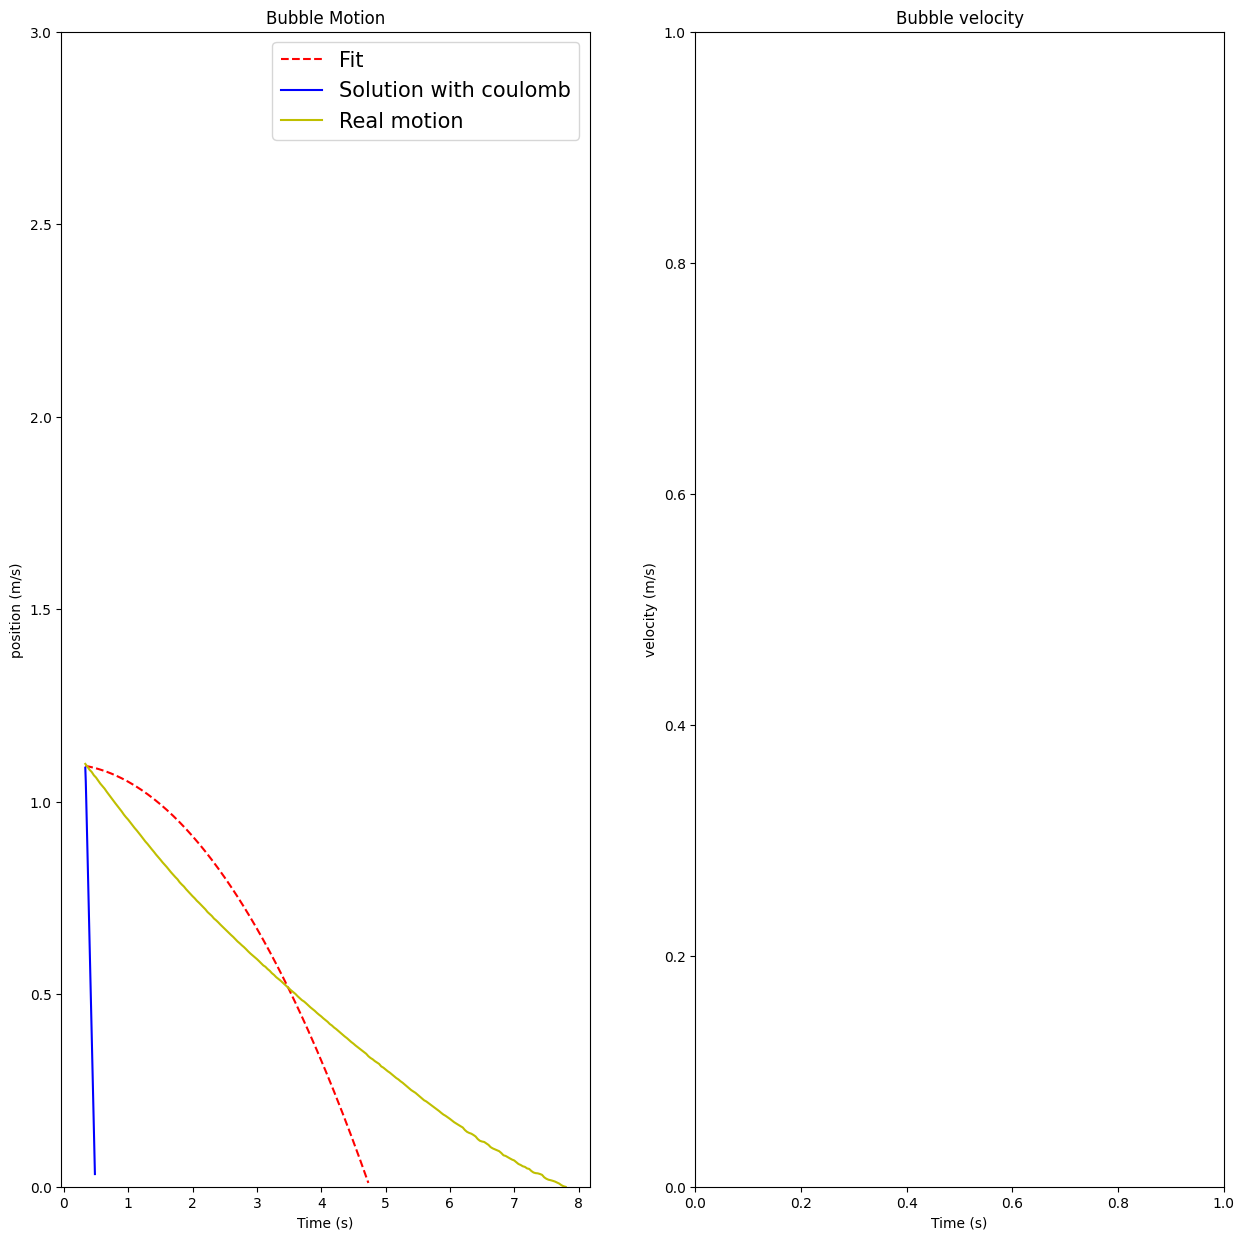

In [15]:
fig, plot = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 15))

plot[0].set_title('Bubble Motion')
plot[0].set_xlabel('Time (s)')
plot[0].set_ylabel('position (m/s)')
plot[0].set_ylim([0, 3])

plot[1].set_title('Bubble velocity')
plot[1].set_xlabel('Time (s)')
plot[1].set_ylabel('velocity (m/s)')

plot[0].plot(time_fit, y_fit, label='Fit', c = 'r', linestyle='--')
plot[0].plot(t, coulomb_position, c = 'b', label = 'Solution with coulomb')
plot[0].plot(np.array(time_data), np.array(real_position), c = 'y', label = 'Real motion')
#plot[1].plot(t, bubble_motion.T[1], c = 'b', label = 'Velocity with coulomb')
plot[0].legend(fontsize = 15)
#plot[1].legend(fontsize = 15)